In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import re
import numpy as np
from collections import Counter

plt.style.use('ggplot')

dataset = pd.read_csv("tweets.csv")

Unique tweets: 17410
All tweets: 17410


[Text(0, 0, 'Actual Tweets'), Text(0, 0, 'Retweets')]

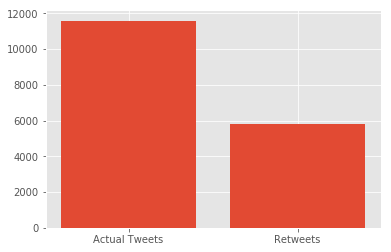

In [4]:
print("Unique tweets: {}".format(len(dataset['tweets'].unique())))
print("All tweets: {}".format(len(dataset['tweets'])))

retweets = []
actual_tweets = []
for user, tweet in zip(dataset['username'], dataset['tweets']):
    match = re.search(r'^\bRT\b', tweet)
    if match == None:
        actual_tweets.append([user,tweet])
    else:
        retweets.append([user,tweet])   

actual_tweets = np.array(actual_tweets)
retweets = np.array(retweets)

plt.bar([1,2], [len(actual_tweets[:,1]), len(retweets[:,1])], align='center')
ax = plt.gca()
ax.set_xticks([1,2])
ax.set_xticklabels(['Actual Tweets', 'Retweets'])

Text(0.5, 1.0, 'Mentioned vs. Total in tweets.csv')

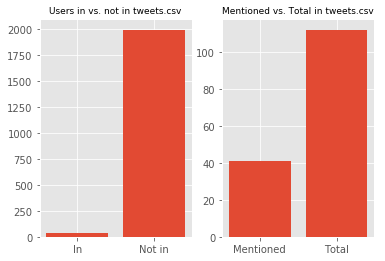

In [5]:
in_set = []
not_in_set = []
for record in actual_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in dataset['username'].unique()) and (record[0] != name[1:]):
                in_set.append([record[0], name[1:]])
            elif record[0] != name[1:]:
                not_in_set.append([record[0], name[1:]])

in_set = np.array(in_set)
not_in_set = np.array(not_in_set)

fig, ax = plt.subplots(1,2)

ax[0].bar([1,2], [len(np.unique(in_set[:,1])), len(np.unique(not_in_set[:,1]))], align='center')
ax[0].set_xticks([1,2])
ax[0].set_xticklabels(['In', 'Not in'])
ax[0].set_title('Users in vs. not in tweets.csv', fontsize=9)

ax[1].bar([1,2], [len(np.unique(in_set[:,1])), len(dataset['username'].unique())], align='center')
ax[1].set_xticks([1,2])
ax[1].set_xticklabels(['Mentioned', 'Total'])
ax[1].set_title('Mentioned vs. Total in tweets.csv', fontsize=9)

In [6]:
sender_count = Counter(in_set[:,0])
receiver_count = Counter(in_set[:,1])
top_5_senders = sender_count.most_common(5)
top_5_receivers = receiver_count.most_common(5)

print(top_5_senders)
print(top_5_receivers)

[('MaghrabiArabi', 49), ('WarReporter1', 30), ('AsimAbuMerjem', 27), ('Uncle_SamCoco', 27), ('moustiklash', 20)]
[('RamiAlLolah', 53), ('Nidalgazaui', 34), ('MilkSheikh2', 26), ('WarReporter1', 15), ('_IshfaqAhmad', 15)]


In [7]:
for name, _ in top_5_receivers:
    print("Username: {} - {}\n".format(name,
            dataset[dataset['username'] == name]['description'].dropna().unique()[0]))

Username: RamiAlLolah - Real-Time News, Exclusives, Intelligence & Classified Information/Reports from the ME. Forecasted many Israeli strikes in Syria/Lebanon. Graphic content.

Username: Nidalgazaui - 17yr. old Freedom Activist
/Correspondence of NGNA /Terror Expert/Middle East Expert. Daily News about Syria/Iraq/Yemen/Russia/Middle East

Username: MilkSheikh2 - Muslim, Iraqi, Banu Zubid, Qahtani, Chef, Engineer, Remaining until the best of them, fights al-Dajjal, Translate Old stuff mostly

Username: WarReporter1 - Reporting on conflicts in the MENA and Asia regions.

Username: _IshfaqAhmad - Medico at GMC Srinagar • Pro-Khilafah • Anti-Democratic • Anti-Nationalistic • Anti-Rafidah • Innocent Bystander of the Conflict in Middle East • Cricketist •



In [8]:
graph = nx.Graph()

all_users = list(set(in_set[:,0]) | set(in_set[:,1]))
graph.add_nodes_from(all_users, count=10)
node_colours = []

for node in graph.nodes():
    if node in (set(in_set[:,0]) & set(in_set[:,1])):
        node_colours.append('g')
    elif node in np.unique(in_set[:,0]):
        node_colours.append('r')
    elif node in np.unique(in_set[:,1]):
        node_colours.append('b')

C:\Users\jtz169\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


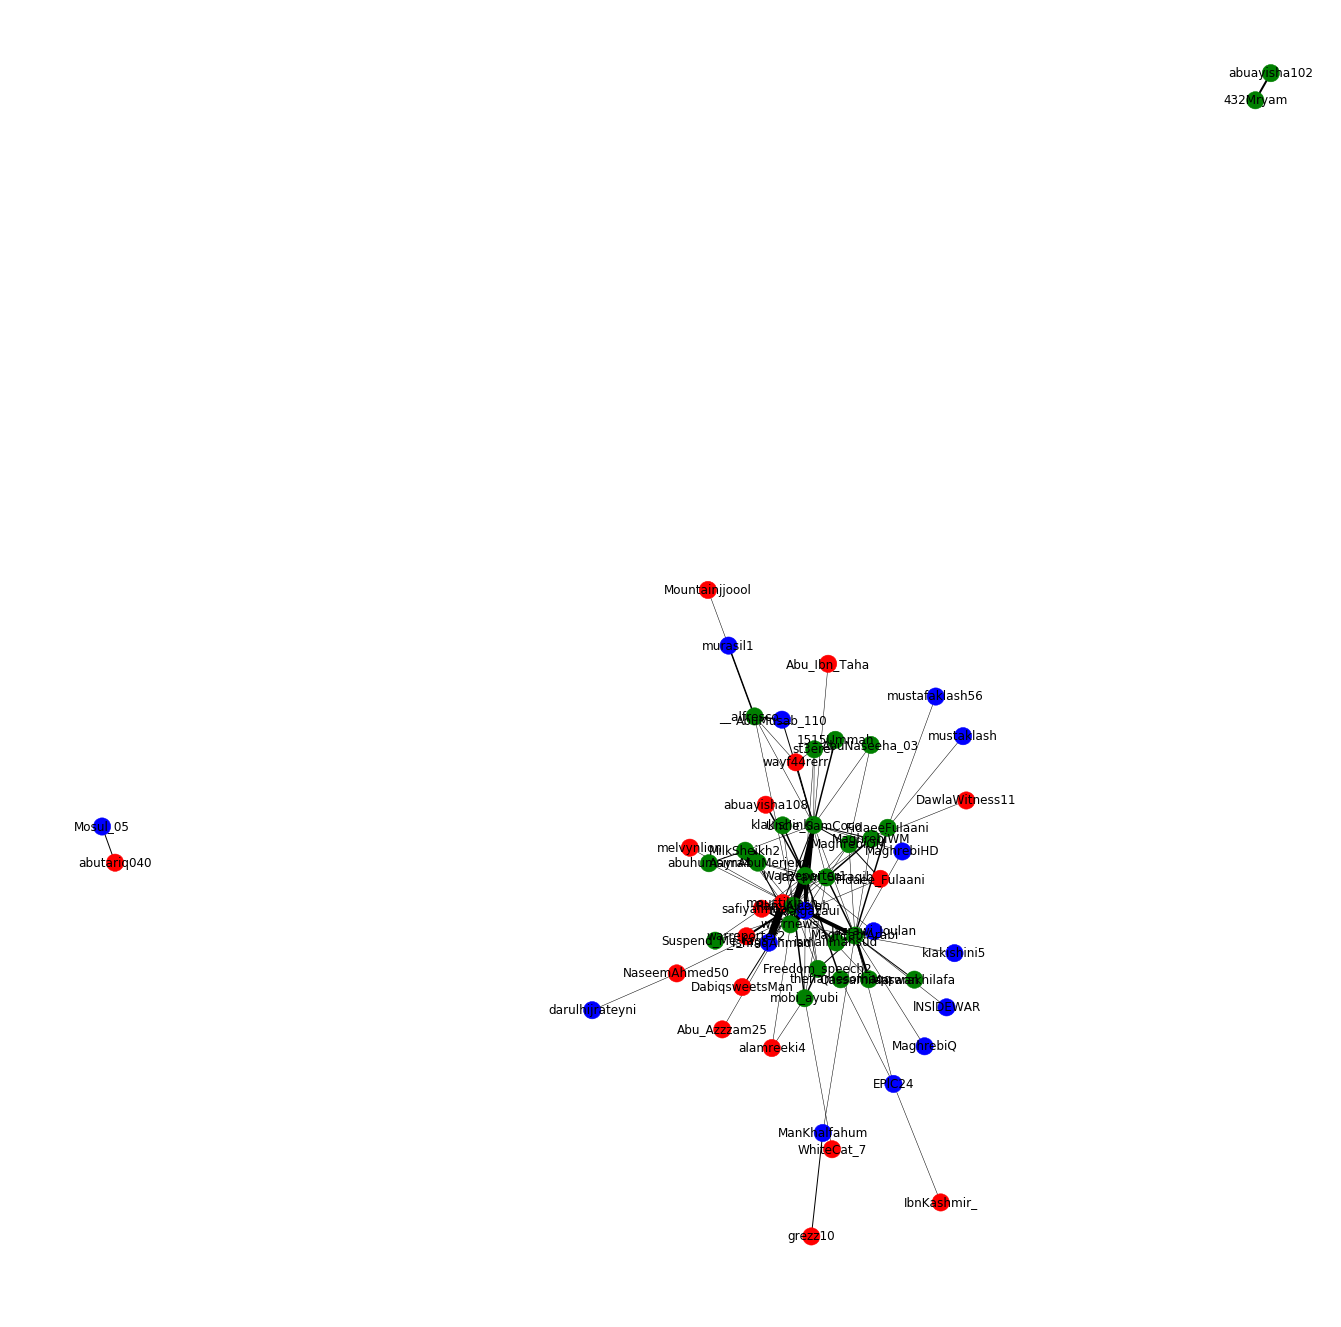

In [9]:
edges = {}
occurrence_count = Counter(map(tuple, in_set))
for (sender, receiver), count in occurrence_count.items():
    if (receiver, sender) in edges.keys():
        edges[(receiver, sender)] = edges[(receiver, sender)] + count
    else:
        edges[(sender, receiver)] = count
        
for (sender, receiver), count in edges.items():
    graph.add_edge(sender, receiver, weight=count)
    
followers = {}
tweet_num = {}
for username in all_users:
    followers[username] = dataset[dataset['username'] == username]['followers'].unique()[-1]
    tweet_num[username] = dataset[dataset['username'] == username]['tweets'].count()

sizes = [(followers[n] / tweet_num[n]) * 50 for n in graph.nodes()]
weights = [graph.edges[u,v]['weight']/2 for u, v in graph.edges()]

plt.figure(figsize=(18,18))
nx.draw(graph, pos=nx.spring_layout(graph),
        node_color=node_colours, with_labels=True, width=weights)
plt.show()

In [10]:


##################################################
##################################################
##### Independ analysis using directed graph #####
##################################################
##################################################



In [11]:
##### To do many analyses we did in the class exercises 
##### we need to do transfer the undirectly network he
##### created into a directed network. So we will only use
##### his codes to handle the data


df=pd.DataFrame(in_set,columns=['sender','receiver'])
df['count']=1

df_count=df.groupby(['sender','receiver']).agg('count').reset_index()[['sender','receiver','count']]



In [12]:
#### Create a network graph####
g_d = nx.from_pandas_edgelist(df_count, 'sender', 'receiver', 'count', create_using=nx.DiGraph)

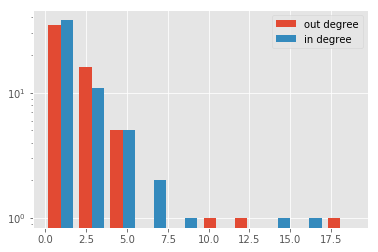

In [13]:
####Create a histogram of in/out degree####

x=list(dict(g_d.out_degree()).values())
y=list(dict(g_d.in_degree()).values())
plt.hist([x,y], log=True ,label=['out degree','in degree'])

plt.legend(loc='upper right')
plt.show()


(array([10.,  2.,  9.,  0.,  9.,  8.,  0., 12.,  7.,  2.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

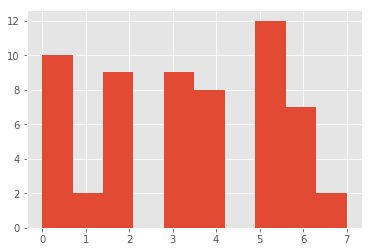

In [14]:
####Partition, althouhg it does not seem to work very well in our case#####
from community import community_louvain

g_u= g_d.to_undirected()
part=community_louvain.best_partition(g_u)

plt.hist(list(part.values()))

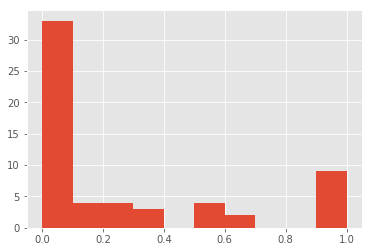

[0, 0.15, 0, 0, 1.0, 0.5333333333333333, 0, 0.15789473684210525, 0, 0.5, 0.25, 0.16666666666666666, 0.6, 0, 0, 0.3333333333333333, 0, 0.09941520467836257, 0, 0, 1.0, 0.25274725274725274, 0.7, 0, 0, 0, 1.0, 0, 0, 1.0, 0, 1.0, 0, 0, 0, 0, 0.2, 0, 0, 1.0, 1.0, 0.18681318681318682, 0.6666666666666666, 1.0, 0, 0, 0.3333333333333333, 0, 0, 0, 0, 1.0, 0, 0, 0.2, 0, 0.5, 0, 0.3333333333333333]


In [33]:
#####This is a graph to show weighted local clustering coefficients#####

x=list(nx.clustering(g_u).values())
plt.hist(x)
###plt.xscale('log') 
plt.show()

print(x)

In [34]:
print('Those are accounts with an coefficient value 1:')
for i in range(len(list(g_u.nodes))):
    if x[i] == 1:
        print (list(g_u.nodes)[i])
        


Those are accounts with an coefficient value 1:
AbuNaseeha_03
Fidaee_Fulaani
MaghrebiHD
QassamiMarwan
ismailmahsud
Suspend_Me_fags
AbuMusab_110
klakishinki
alamreeki4


The clustering coefficient captures the degree to which the neighbors of a given node link to each other. for a node with degree k, the local clustering coefficient is defined as C= 2L/(K*(k-1)), where L represents the number of links beween the K neighbors of this node. C is between 0 and 1. C is the probability that two neighbors of a node linke to each other. C=0 means none of the neighbors of the node link to each other while C = 1 means all neighbors of this node are linked. We can see that the majority of the nodes have a coefficient equal or close to 0 , which means their neighbors are not very well connected. We can see that there are 9 nodes with clutering coefficient 1, which are the accounts that are probably in a central location and have a very dense and well connected neighborshood.

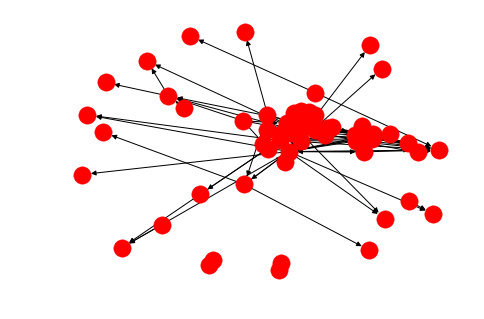

In [14]:
#### Try to draw a graph of the directed network 



#### This might produce a better directed graph but it's not working on my laptop ####
#from netwulf import visualize 
#visualize(g_d,config={
#        'Node size': 11,
#        'Charge strength' : -0.8,
#        'Link distance' : 10,
#        'Link width' : 1,
#        'Collision' : True,
#        'Min. link weight %': 80,
#    })

G=nx.draw(g_d)


In [15]:
#### The triangle fraction in the network ####


from scipy.special import binom

def make_net(el_, nodes):
    '''
    Convert edgelist to networkx graph which is 
    binary and undirected.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''    
    nx_input = el_, 'sender', 'receiver', 'count', nx.Graph()
    g = nx.from_pandas_edgelist(*nx_input)
    g.add_nodes_from(nodes)
    return g


def fraction_triangles(el_, nodes):
    '''
    Compute fraction of actual triangles out 
    of the potential triangles.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''
    
    g = make_net(el_, nodes)

    A = nx.to_scipy_sparse_matrix(g)
    A_t = A**3
    a_t = A_t.diagonal().sum()/6

    # count potential triangles
    n = len(g.nodes())
    p_t = binom(n, 3)
        
    return a_t/p_t



In [16]:
#### The triangle fraction in the network ####

nodes=np.array(graph.nodes())

print('The triangle fraction in the network is', fraction_triangles(df_count,nodes), 'for the network')

The triangle fraction in the network is 0.0017533606078316774 for the network
